## GAN from Scratch

### Import Libraries

In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T # Transformation functions to manipulate images

import torch.nn.functional as F # various activation functions for model
import torchvision # You can load various Pretrained Model from this package
# import torchvision.datasets as vision_dsets
import torch.optim as optim # various optimization functions for model
from torch.autograd import Variable 
# from torch.utils import data

In [2]:
import os
import numpy as np

### Visualization Setup

In [3]:
import random
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt

random_seed = 999
print(f"Randon Seed: {random_seed}")
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
cudnn.benchmark = False
cudnn.deterministic = True
np.random.seed(random_seed) # for numpy-based backend, scikit-learn

Randon Seed: 999


### Dataset Preprocessing

In [4]:
MNIST_dir = "../MNIST/"
train_imgs_dir = os.path.join(MNIST_dir, 'train-images-idx3-ubyte')
train_labels_dir = os.path.join(MNIST_dir, 'train-labels-idx1-ubyte')
test_imgs_dir = os.path.join(MNIST_dir, 't10k-images-idx3-ubyte')
test_labels_dir = os.path.join(MNIST_dir, 't10k-labels-idx1-ubyte')

In [5]:
import struct
import matplotlib.pyplot as plt
import matplotlib.cm as cm

train_imgs_file = open(train_imgs_dir,'rb')
train_labels_file = open(train_labels_dir,'rb')
train_img = np.zeros((28,28))
train_label = -1
img = train_imgs_file.read(16)
label = train_labels_file.read(8)

img = train_imgs_file.read(28*28)
img = np.reshape(struct.unpack(len(img)*'B',img), (28,28))
label = train_labels_file.read(1)

plt.imshow(img, cmap='gray') 
plt.show()

"\nimport struct\nimport matplotlib.pyplot as plt\nimport matplotlib.cm as cm\n\ntrain_imgs_file = open(train_imgs_dir,'rb')\ntrain_labels_file = open(train_labels_dir,'rb')\ntrain_img = np.zeros((28,28))\ntrain_label = -1\nimg = train_imgs_file.read(16)\nlabel = train_labels_file.read(8)\n\nimg = train_imgs_file.read(28*28)\nimg = np.reshape(struct.unpack(len(img)*'B',img), (28,28))\nlabel = train_labels_file.read(1)\n\nplt.imshow(img, cmap='gray') \nplt.show()\n"

### Custom Dataset

In [6]:
import pandas as pd
import struct

class MNISTDataset(Dataset):
    def __init__(self, imgs_dir, labels_dir, len, transform=None, target_transform=None):
        # open file
        self.imgs_file = open(imgs_dir,'rb')
        self.labels_file = open(labels_dir,'rb')
        # initialize
        dummy_imgs = self.imgs_file.read(16)
        dummy_labels = self.labels_file.read(8)
        imgs = self.imgs_file.read()
        labels = self.labels_file.read()
        # self.imgs = np.reshape(struct.unpack(len(imgs)*'B',imgs), (-1,28,28))
        self.imgs = np.frombuffer(imgs, dtype=np.uint8).reshape((-1,28,28))
        self.labels = np.frombuffer(labels,dtype=np.uint8)
        self.len = len
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # return length
        # usually directly calculated from csv idx length
        return self.len

    def __getitem__(self, idx):
        # convert file format (be careful!)
        img = self.imgs[idx].astype(np.uint8)
        label = int(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

### Transform

In [21]:
# PIL image or numpy array(uint8) -> float tensor ; change intensity in range [0.0, 1.1] (include normalizing)
# For data aug and transforming, we can include many transform functions using nn.Sequential
# Normalization is depend on channel (RGB)
transform = T.Compose([T.ToTensor(), T.Normalize(mean=(0.5, 0.5,0.5),std=(0.5, 0.5,0.5))])
transform = T.ToTensor()
# one-hot-vector ; make zero tensor and assign 1 on the index given by the label y
target_transform = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0,torch.tensor(y),value=1))

training_data = MNISTDataset(train_imgs_dir, train_labels_dir, 60000, transform, target_transform)
test_data = MNISTDataset(test_imgs_dir, test_labels_dir, 10000, transform, target_transform)

TypeError: list is not a Module subclass

In [8]:
print(training_data.imgs.shape)
print(training_data.labels.shape)
type(training_data.labels[0])

(60000, 28, 28)
(60000,)


numpy.uint8

### Iterating and Visulaizing the Dataset

In [ ]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = torch.tensor([i+100])
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
img, label = training_data[5990]
print(label)

### Dataloader

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False) # don't need to shuffle ; model.eval()

In [10]:
'''
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
# print(img)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
'''

'\n# Display image and label.\ntrain_features, train_labels = next(iter(train_dataloader))\nprint(f"Feature batch shape: {train_features.size()}")\nprint(f"Labels batch shape: {train_labels.size()}")\nimg = train_features[0].squeeze()\n# print(img)\nlabel = train_labels[0]\nplt.imshow(img, cmap="gray")\nplt.show()\nprint(f"Label: {label}")\n'

### Build the Network

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

##### Discriminator

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

##### Generator

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            # nn.Unflatten(1, torch.Size([1,28,28])),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

##### Device Setting

In [14]:
D = Discriminator().to(device)
G = Generator().to(device)
print(D)
print(G)

Discriminator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
Generator(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Tanh()
  )
)


In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

## Optimizing and Model Parameters

### Hyperparameters

In [15]:
learning_rate = 1e-4
batch_size = 32
epochs = 5

### Optimization Loop

##### Simple Neural Network

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        pred = model(X).to(device)
        y = y.to(device)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print(f"batch: {batch}, x: {X.size()}, y: {y.size()}")
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            pred = model(X).to(device)
            y = y.to(device)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.max(1).indices).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # model.train()
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # model.eval()
    # test_loop(test_dataloader, model, loss_fn)
print("Done!")

NameError: name 'model' is not defined

##### GAN

In [18]:
def train_loop(dataloader, d_model, g_model, loss_fn, d_optimizer, g_optimizer):
    d_model.train()
    g_model.train()
    size = len(dataloader.dataset)
    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        #################
        # Discriminator #
        #################
        
        # Compute prediction and loss
        pred_from_real = d_model(X).to(device)
        d_real_loss = loss_fn(pred_from_real, real_labels)

        z = torch.randn((batch_size, 64), device=device, requires_grad=True)
        pred_from_fake = d_model(g_model(z)).to(device)
        d_fake_loss = loss_fn(pred_from_fake, fake_labels)
        
        d_pred = pred_from_real + pred_from_fake # score
        d_loss = d_real_loss + d_fake_loss
        
        # Backpropagation
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        #################
        #   Generator   #
        #################
        
        # Compute prediction and loss
        z = torch.randn(batch_size, 64, device=device, requires_grad=True)
        g_pred = d_model(g_model(z)).to(device)
        g_loss = loss_fn(g_pred, real_labels)
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # print(f"batch: {batch}, x: {X.size()}, y: {y.size()}")
        if batch % 100 == 0:
            # print(type(d_loss))
            current = (batch+1) * len(X)
            print(f"d_loss: {d_loss}, g_loss: {g_loss}   [{current:>5d}/{size:>5d}]")
            

def test_loop(dataloader, d_model, g_model, loss_fn, d_optimizer, g_optimizer):
    d_model.eval()
    g_model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, _) in enumerate(dataloader):
            if batch == 0:
                X = X.to(device)
                real_pred = d_model(X).to(device)
                
                z = torch.randn(batch_size, 64, device=device)
                fake_img = g_model(z).to(device)
                fake_pred = d_model(fake_img).to(device)
            else:
                continue

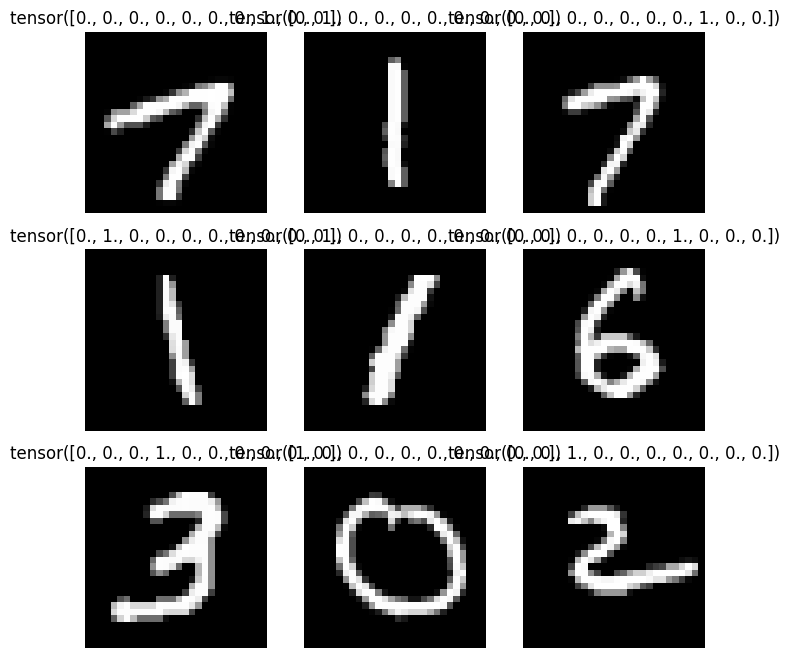

In [19]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # sample_idx = torch.randint(len(training_data), size=(1,)).item()
    sample_idx = torch.tensor([i+100])
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [20]:
loss_fn = nn.BCELoss()
discriminator_optimizer = torch.optim.SGD(D.parameters(), lr=learning_rate)
generator_optimizer = torch.optim.SGD(G.parameters(), lr=learning_rate)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # model.train()
    train_loop(train_dataloader, D, G, loss_fn, discriminator_optimizer, generator_optimizer)
    # model.eval()
    # test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
d_loss: 1.3827431201934814, g_loss: 0.7267686724662781   [    0/60000]
d_loss: 1.3804008960723877, g_loss: 0.7258186340332031   [ 3200/60000]
d_loss: 1.3784444332122803, g_loss: 0.7273058891296387   [ 6400/60000]
d_loss: 1.3752657175064087, g_loss: 0.7281578779220581   [ 9600/60000]
d_loss: 1.375802993774414, g_loss: 0.7272291779518127   [12800/60000]
d_loss: 1.3722286224365234, g_loss: 0.7263746857643127   [16000/60000]
d_loss: 1.3712382316589355, g_loss: 0.7271057367324829   [19200/60000]
d_loss: 1.3708624839782715, g_loss: 0.7242575287818909   [22400/60000]
d_loss: 1.3645436763763428, g_loss: 0.7270920276641846   [25600/60000]
d_loss: 1.3659586906433105, g_loss: 0.7263577580451965   [28800/60000]
d_loss: 1.3610713481903076, g_loss: 0.7250024080276489   [32000/60000]
d_loss: 1.3586312532424927, g_loss: 0.7252992391586304   [35200/60000]
d_loss: 1.3565764427185059, g_loss: 0.7251865863800049   [38400/60000]
d_loss: 1.3565078973770142, g_loss: 0.